In [8]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as rq
import numpy as np
import time
import pickle
from io import BytesIO
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from collections import Counter
import cv2
import itertools
import seaborn as sns
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /home/pidoux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Scrap des images pour un hashtag

In [9]:
USERNAME = 'sosorezka@gmail.com'
PASSWORD = 'sofia2001'

In [10]:
def scrap_by_hashtag(nb_max = 50, hashtag='chat'): 

    options = webdriver.ChromeOptions()
    options.headless = True  # Exécution sans interface graphique

    # Initialiser le navigateur Chrome sans spécifier executable_path
    driver = webdriver.Chrome(options=options)

    # Accéder à la page de connexion de Pixelfed
    login_url = 'https://pixelfed.social/login'
    driver.get(login_url)

    # Remplir le formulaire de connexion
    username = USERNAME
    password =  PASSWORD

    username_field = driver.find_element(By.NAME, 'email')
    password_field = driver.find_element(By.NAME, 'password')

    username_field.send_keys(username)
    password_field.send_keys(password)

    # Soumettre le formulaire de connexion
    login_button = driver.find_element(By.CSS_SELECTOR, "button.btn.btn-primary.btn-block.btn-lg.font-weight-bold")
    ActionChains(driver).move_to_element(login_button).click().perform()

    driver.implicitly_wait(10)
    
    # Ouvrir une nouvelle fenêtre
    new_window = driver.execute_script("window.open('https://pixelfed.social/i/web/hashtag/{}', 'new_window');".format(hashtag))

    # Changer la fenêtre active
    driver.switch_to.window(driver.window_handles[-1])

    liste_url = []
    liste_img = []
    pbar = tqdm(desc= 'while_loop', total=nb_max)
    while len(liste_url)<nb_max :
        
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        
        time.sleep(1)
        print(len(liste_url))
        post =driver.find_element(By.CSS_SELECTOR, "div.row.mx-0.hashtag-feed")
        #print(post)
        # Trouver les images
        images = post.find_elements(By.CSS_SELECTOR, "img")
        val = 0
        for image in tqdm(images) :
            image_url = image.get_attribute('src')
            if image_url not in liste_url : 
                try : 
                    response = rq.get(image_url)
                    img = np.array(Image.open(BytesIO(response.content)))
                    if img.shape[2]==3 and img.shape[0]>512 and img.shape[1]>512: #si l'image est en couleur et a une shape plus grande que 128x128
                        liste_url.append(image_url)
                        liste_img.append(img)
                        print(len(liste_img))
                        val+=1
                        pbar.update(val)
                except:
                    print("erreur get")
            
    df = pd.DataFrame({'url':liste_url, 'image':liste_img})
    print(len(liste_url))
    
    # Fermer la fenêtre
    driver.close()

    # Récupérer la fenêtre principale
    driver.switch_to.window(driver.window_handles[0])

    # Fermer le navigateur
    driver.quit()

    with open(f'dataframe_{hashtag}.pkl', 'wb') as file : 
        pickle.dump(df, file)
    return df

In [4]:
#train = scrap_by_hashtag(nb_max=20, hashtag='cat')

In [5]:
#test = scrap_by_hashtag(nb_max=200, hashtag='cat')

In [6]:
#test.head(5)

NameError: name 'test' is not defined

In [6]:
#img = test.iloc[0]['image']
#plt.imshow(img)

# Test de l'enregistrement du pickle 

In [11]:
with open('dataframe_cat.pkl', 'rb') as file : 
    df = pickle.load(file)
df.head(2)
test = df


#  Description des images

In [12]:
images =  test.iloc[:]['image']

In [13]:
def analyse_taille_images(images):
    shape_images = [img.shape for img in images]
    df_shape = pd.DataFrame(shape_images, columns=['height', 'width', 'channel'])
    df_shape['height*width'] = df_shape['height'] * df_shape['width']
    df_shape['width/height'] = df_shape['width'] / df_shape['height']
    df_shape = df_shape[["height", "width", "height*width", 'width/height',"channel"]]
    return df_shape , df_shape.describe()

_ , describe = analyse_taille_images(images)
describe

,height,width,height*width,width/height,channel
count,52.000000,52.000000,5.200000e+01,52.000000,52.0
mean,1601.480769,1577.788462,2.933911e+06,1.030780,3.0
std,781.213950,783.411502,2.681796e+06,0.331329,0.0
min,575.000000,567.000000,4.020030e+05,0.450195,3.0
25%,1108.250000,1023.500000,1.167208e+06,0.750075,3.0
50%,1425.000000,1223.500000,1.841152e+06,1.000000,3.0
75%,1706.250000,2012.000000,3.125747e+06,1.333333,3.0
max,3838.000000,3534.000000,8.295105e+06,1.777778,3.0


Nombre d'images :  3000000


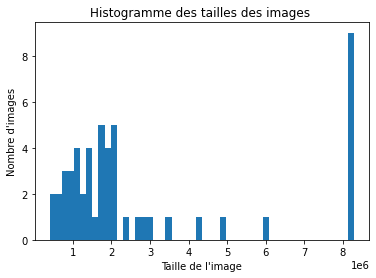

In [14]:
def histogramme_tailles(images,bins=50):
    tailles_images = [img.shape[0]*img.shape[1] for img in images]
    print('Nombre d\'images : ', tailles_images[0])
    plt.hist(tailles_images, bins=bins)
    plt.xlabel('Taille de l\'image')
    plt.ylabel('Nombre d\'images')
    plt.title('Histogramme des tailles des images ')
    plt.show()
hist = histogramme_tailles(images)

In [15]:
def resize_and_crop_image(image, deformation, target_size=512):
    
    # Calculez l'aspect ratio
    height, width, _ = image.shape
    aspect_ratio = width / height
    
    # Déterminez si l'image doit être recadrée ou redimensionnée
    if 1-deformation <= aspect_ratio <= 1+deformation:
        # Redimensionnez en 512x512 sans recadrer
        resized_image = cv2.resize(image, (512, 512))
    else:
        # Recadrez en centrant en fonction de la plus petite dimension
        if aspect_ratio > 1:

            new_width = height
            marge = (width - new_width) // 2
            cropped_image = image[:, marge:marge+new_width, :]
            resized_image = cv2.resize(cropped_image, (target_size, target_size))
        else:
            new_height = width
            marge = (height - new_height) // 2
            cropped_image = image[marge:marge+new_height, :, :]
            resized_image = cv2.resize(cropped_image, (target_size, target_size))

    return resized_image

result_image = resize_and_crop_image(images[2], 0.2)

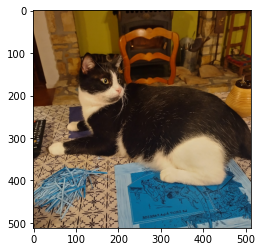

In [16]:
result_image = resize_and_crop_image(images[0], 0.2,512)
plt.imshow(result_image)

In [17]:
def redimensionner_images(images, deformation =0.1, target_size = 512):
    images_redimensionnees = []
    for image in images:
        image_redimensionnee = resize_and_crop_image(image, deformation, target_size)
        images_redimensionnees.append(image_redimensionnee)
    return images_redimensionnees

In [18]:
images_redim = redimensionner_images(images, 0.1, 512)

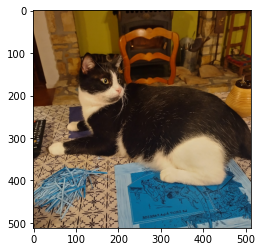

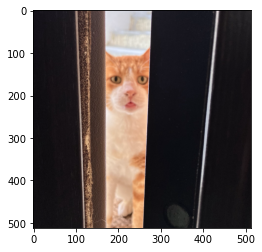

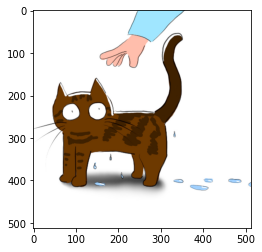

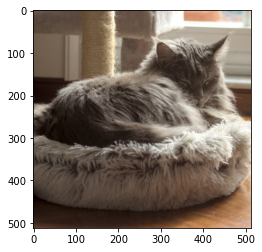

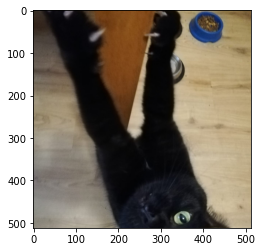

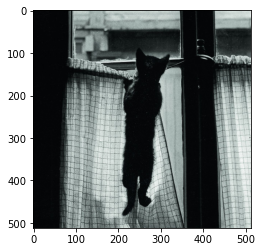

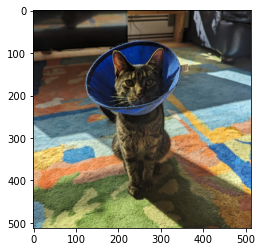

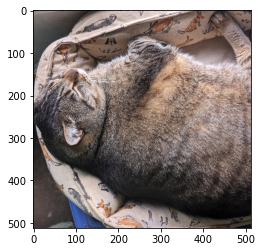

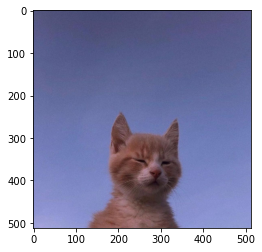

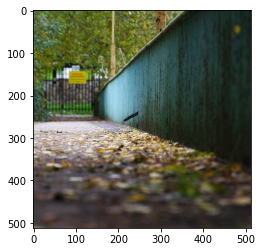

In [19]:
for i in range(10):
    plt.imshow(images_redim[i])
    plt.show()

In [109]:
def normalise(images):
    output =[]
    for image in images:
        image = image / 255
        output.append(image)
    return output

In [22]:
def image_moyenne(images):
    w,h,c = np.array(images[0]).shape #toutes les images ont les mêmes dimensions (width, height, color space)

    # Calcul de l'image moyenne
    avg_image = np.zeros((h, w, c), np.float32)

    for img in images:
        avg_image += np.array(img) / len(images)

    avg_image = np.round(avg_image).astype(np.uint8)

    return avg_image

avg_image = image_moyenne(images_redim)

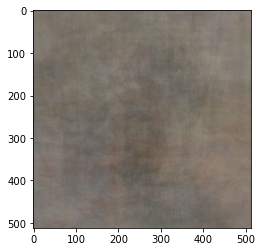

In [23]:
plt.imshow(avg_image)

In [24]:
def dynamique_luminosite(images):
    mean_red = []
    min_red = []
    max_red = []
    mean_green = []
    min_green = []
    max_green = []
    mean_blue = []
    min_blue = []
    max_blue = []
    variance_red = []
    variance_green = []
    variance_blue = []

    # Parcourez chaque image dans la liste
    for image in images:
        # Lisez l'image en utilisant OpenCV
        
        # Séparez les canaux de couleur
        blue, green, red = cv2.split(image)
        
        # Calculez la moyenne et la variance pour chaque canal
        mean_red.append(red.mean())
        mean_green.append(green.mean())
        mean_blue.append(blue.mean())
        min_red.append(red.min())
        min_green.append(green.min())   
        min_blue.append(blue.min())
        max_red.append(red.max())
        max_green.append(green.max())
        max_blue.append(blue.max())
        variance_red.append(red.var())
        variance_green.append(green.var())
        variance_blue.append(blue.var())

    # Créez un DataFrame Pandas
    data = {
        'Mean_Red': mean_red,
        'Mean_Green': mean_green,
        'Mean_Blue': mean_blue,
        'Variance_Red': variance_red,
        'Variance_Green': variance_green,
        'Variance_Blue': variance_blue,
        'Min_Red': min_red,
        'Min_Green': min_green,
        'Min_Blue': min_blue,
        'Max_Red': max_red,
        'Max_Green': max_green,
        'Max_Blue': max_blue
    }

    return pd.DataFrame(data)



In [25]:
df = dynamique_luminosite(images_redim)
df.describe()

,Mean_Red,Mean_Green,Mean_Blue,Variance_Red,Variance_Green,Variance_Blue,Min_Red,Min_Green,Min_Blue,Max_Red,Max_Green,Max_Blue
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,104.082025,113.407096,121.502206,3531.031283,3653.917707,3927.365156,2.057692,2.596154,2.980769,242.884615,244.980769,247.423077
std,42.768162,37.611257,37.853415,1794.094796,1539.474205,1577.192899,7.652793,7.198201,7.269303,22.849597,18.503302,14.883003
min,41.462616,42.638489,53.119209,296.004751,274.395364,454.817465,0.000000,0.000000,0.000000,151.000000,168.000000,190.000000
25%,68.752820,89.970942,97.587368,2462.494093,2738.171858,2992.478761,0.000000,0.000000,0.000000,237.500000,245.750000,249.750000
50%,95.266319,104.937504,113.458033,3270.231925,3668.902972,3786.195199,0.000000,0.000000,0.000000,255.000000,254.000000,255.000000
75%,127.002415,132.215181,145.745008,4545.335906,4566.783209,4599.618621,0.000000,1.000000,2.000000,255.000000,255.000000,255.000000
max,219.080620,219.264999,221.520706,8814.858781,7916.095725,7933.523154,42.000000,39.000000,39.000000,255.000000,255.000000,255.000000


# Description des tags

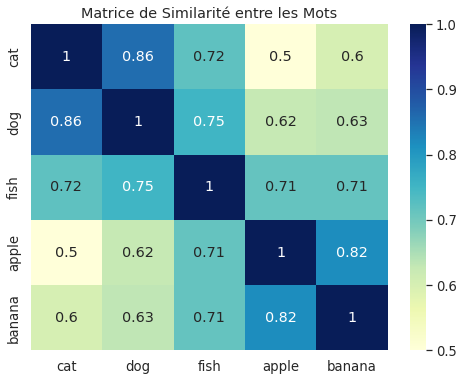

array([[1.        , 0.85714286, 0.72      , 0.5       , 0.6       ],
       [0.85714286, 1.        , 0.75      , 0.625     , 0.63157895],
       [0.72      , 0.75      , 1.        , 0.71428571, 0.71428571],
       [0.5       , 0.625     , 0.71428571, 1.        , 0.81818182],
       [0.6       , 0.63157895, 0.71428571, 0.81818182, 1.        ]])

In [26]:
# Fonction pour calculer la similarité entre deux mots en utilisant WordNet
def wordnet_similarity(word1, word2):
    synsets1 = wordnet.synsets(word1)
    synsets2 = wordnet.synsets(word2)
    
    max_similarity = 0
    
    for synset1 in synsets1:
        for synset2 in synsets2:
            similarity = synset1.wup_similarity(synset2)  # Utilisation de la similarité de Wu-Palmer
            if similarity is not None and similarity > max_similarity:
                max_similarity = similarity
    
    return max_similarity

def matr_sim(word_list):
    similarity_matrix = np.zeros((len(word_list), len(word_list)))

    for i, word1 in enumerate(word_list):
        for j, word2 in enumerate(word_list):
            similarity = wordnet_similarity(word1, word2)
            similarity_matrix[i][j] = similarity

    # Utilisation de Seaborn pour créer une carte de chaleur
    sns.set(font_scale=1.2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, xticklabels=word_list, yticklabels=word_list, cmap="YlGnBu")
    plt.title("Matrice de Similarité entre les Mots")
    plt.show()
    return similarity_matrix

word_list = ["cat", "dog", "fish", "apple", "banana"]

matr_sim(word_list)

In [76]:
def hierarchie(liste_tag):
    dic ={}
    for tag in liste_tag:
        synsets = wordnet.synsets(tag)[0]
        if tag+'.n.01' not in dic:
            dic[tag+'.n.01'] = [hypo.name() for hypo in synsets.hyponyms()]
        else:
            dic[tag+'.n.01']+=([hypo.name() for hypo in synsets.hyponyms()])
    return dic
d = hierarchie(word_list)
print(d)
    

{'cat.n.01': ['domestic_cat.n.01', 'wildcat.n.03'], 'dog.n.01': ['basenji.n.01', 'corgi.n.01', 'cur.n.01', 'dalmatian.n.02', 'great_pyrenees.n.01', 'griffon.n.02', 'hunting_dog.n.01', 'lapdog.n.01', 'leonberg.n.01', 'mexican_hairless.n.01', 'newfoundland.n.01', 'pooch.n.01', 'poodle.n.01', 'pug.n.01', 'puppy.n.01', 'spitz.n.01', 'toy_dog.n.01', 'working_dog.n.01'], 'fish.n.01': ['bony_fish.n.01', 'bottom-feeder.n.02', 'bottom_lurkers.n.01', 'cartilaginous_fish.n.01', 'climbing_perch.n.01', 'fingerling.n.01', 'food_fish.n.01', 'game_fish.n.01', 'mouthbreeder.n.01', 'northern_snakehead.n.01', 'rough_fish.n.01', 'spawner.n.01', 'young_fish.n.01'], 'apple.n.01': ['cooking_apple.n.01', 'crab_apple.n.03', 'eating_apple.n.01'], 'banana.n.01': ['abaca.n.02', 'dwarf_banana.n.01', 'edible_banana.n.01', 'japanese_banana.n.01', 'plantain.n.02']}


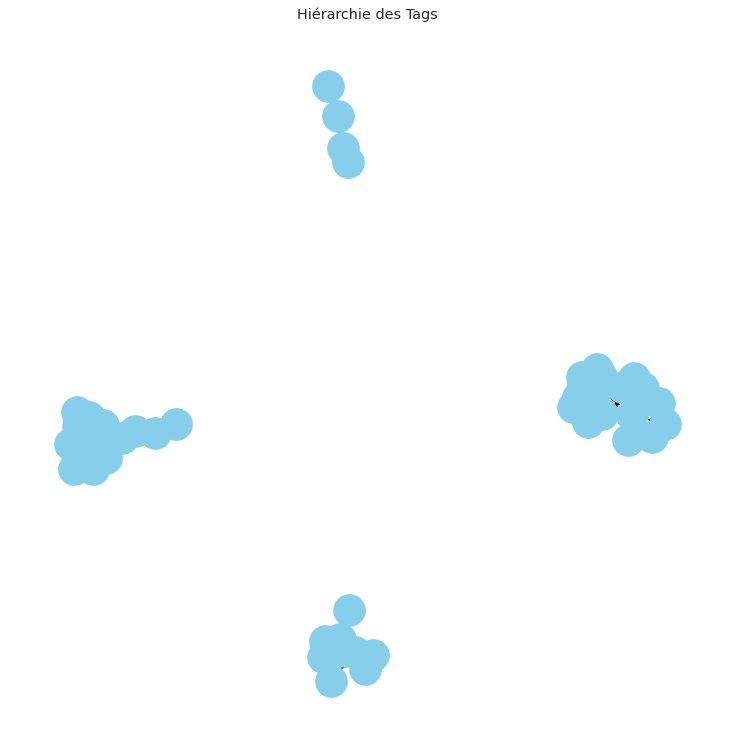

In [98]:
import networkx as nx
def graphe_hierarchie(liste_tag,dic_hierarchie,label =False):
    # Créez un graphe dirigé
    G = nx.DiGraph()

    # Ajoutez les arêtes au graphe en utilisant les données de tags
    for tag, parent_tags in dic_hierarchie.items():
        for p in parent_tags:
            G.add_edge(p, tag)
            for i in liste_tag:
                if i+'.n.01' == p:
                    G.add_edge(i, p)


    # Visualisation du graphe
    pos = nx.spring_layout(G)  # Positionnement des nœuds
    plt.figure(figsize=(10,10))
    nx.draw(G, pos, with_labels=label, node_size=1000, node_color="skyblue", font_size=20, arrows=True)
    plt.title("Hiérarchie des Tags")
    plt.show()

graphe_hierarchie(word_list,d)

In [103]:
def reshape_normalize(images, target_size, deformation, hashtag):
    images = redimensionner_images(images, deformation =0.1, target_size = 512)
    images = normalise(images)
    df = pd.DataFrame({'image':images})
    with open(f'images_{hashtag}.pkl', 'wb') as file : 
        pickle.dump(df, file)
    return df

In [111]:
reshape_normalize(images,512,0.1,'cat')

,image
0,"[[[0.6431372549019608, 0.48627450980392156, 0...."
1,"[[[0.08627450980392157, 0.07450980392156863, 0..."
2,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
3,"[[[0.41568627450980394, 0.34901960784313724, 0..."
4,"[[[0.2196078431372549, 0.1803921568627451, 0.1..."
5,"[[[0.01568627450980392, 0.01568627450980392, 0..."
6,"[[[0.10588235294117647, 0.10588235294117647, 0..."
7,"[[[0.3215686274509804, 0.3058823529411765, 0.2..."
8,"[[[0.30980392156862746, 0.3176470588235294, 0...."
9,"[[[0.32941176470588235, 0.4627450980392157, 0...."


In [116]:
# A FINIR ...


def analyse_images(images,bins = 20):
    df_shape,describe = analyse_taille_images(images)
    describe
    histogramme_tailles(images, bins = 20)
    dyn = dynamique_luminosite(images)
    dyn
    i = image_moyenne(images)
    plt.show(images)
    retun 
    

Nombre d'images :  3000000


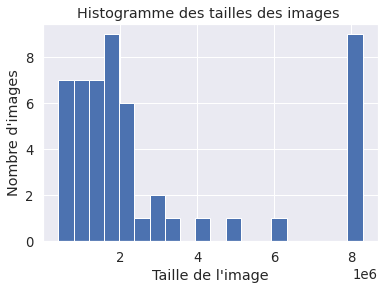

ValueError: operands could not be broadcast together with shapes (2000,1500,3) (1500,2000,3) (2000,1500,3) 

In [117]:
analyse_images(images)
df_shape,describe